# Task 3: Predictive Analytics for Resource Allocation
## Breast Cancer Image Classification using Random Forest

This notebook implements a machine learning pipeline for breast cancer classification using image features.

## 1. Import Libraries and Setup

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import logging

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Custom modules
from data_preprocessing import ImageDataPreprocessor
from evaluation import ModelEvaluator, get_feature_names

# Set random seed for reproducibility
np.random.seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading and Preprocessing

In [2]:
# Initialize preprocessor
dataset_path = "../../iuss-23-24-automatic-diagnosis-breast-cancer"
preprocessor = ImageDataPreprocessor(dataset_path, image_size=(128, 128))

print(f"Dataset path: {dataset_path}")
print(f"Image size: {preprocessor.image_size}")

Dataset path: ../../iuss-23-24-automatic-diagnosis-breast-cancer
Image size: (128, 128)


In [3]:
# Load and preprocess data
print("Loading and preprocessing data...")
X_train, X_test, y_train, y_test = preprocessor.prepare_data(test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Feature dimensions: {X_train.shape[1]}")
print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Test labels distribution: {np.bincount(y_test)}")

Loading and preprocessing data...


INFO:data_preprocessing:Loaded 565 images: 404 benign, 161 malignant
INFO:data_preprocessing:Data prepared: Train=(452, 12), Test=(113, 12)


Training set shape: (452, 12)
Test set shape: (113, 12)
Feature dimensions: 12
Training labels distribution: [323 129]
Test labels distribution: [81 32]


## 3. Exploratory Data Analysis

In [4]:
# Create DataFrame for easier analysis
feature_names = get_feature_names()
df_train = pd.DataFrame(X_train, columns=feature_names)
df_train['label'] = y_train
df_train['class'] = df_train['label'].map({0: 'Benign', 1: 'Malignant'})

print("Dataset Summary:")
print(df_train.describe())

Dataset Summary:
       Mean_Intensity  Std_Intensity  Var_Intensity  Min_Intensity  \
count    4.520000e+02   4.520000e+02   4.520000e+02          452.0   
mean    -9.431983e-17   7.309787e-16   1.414797e-16            0.0   
std      1.001108e+00   1.001108e+00   1.001108e+00            0.0   
min     -5.726426e+00  -7.360590e+00  -5.974315e+00            0.0   
25%      1.720505e-01   1.478973e-01   1.270451e-01            0.0   
50%      1.813132e-01   1.733536e-01   1.625867e-01            0.0   
75%      1.896731e-01   1.903291e-01   1.863436e-01            0.0   
max      8.377911e-01   4.985688e+00   8.684960e+00            0.0   

       Max_Intensity  Median_Intensity  Percentile_25  Percentile_75  \
count          452.0      4.520000e+02   4.520000e+02   4.520000e+02   
mean             0.0     -4.715992e-17   2.043596e-16   4.480192e-16   
std              0.0      1.001108e+00   1.001108e+00   1.001108e+00   
min              0.0     -5.214546e+00  -5.079481e+00  -5.376241

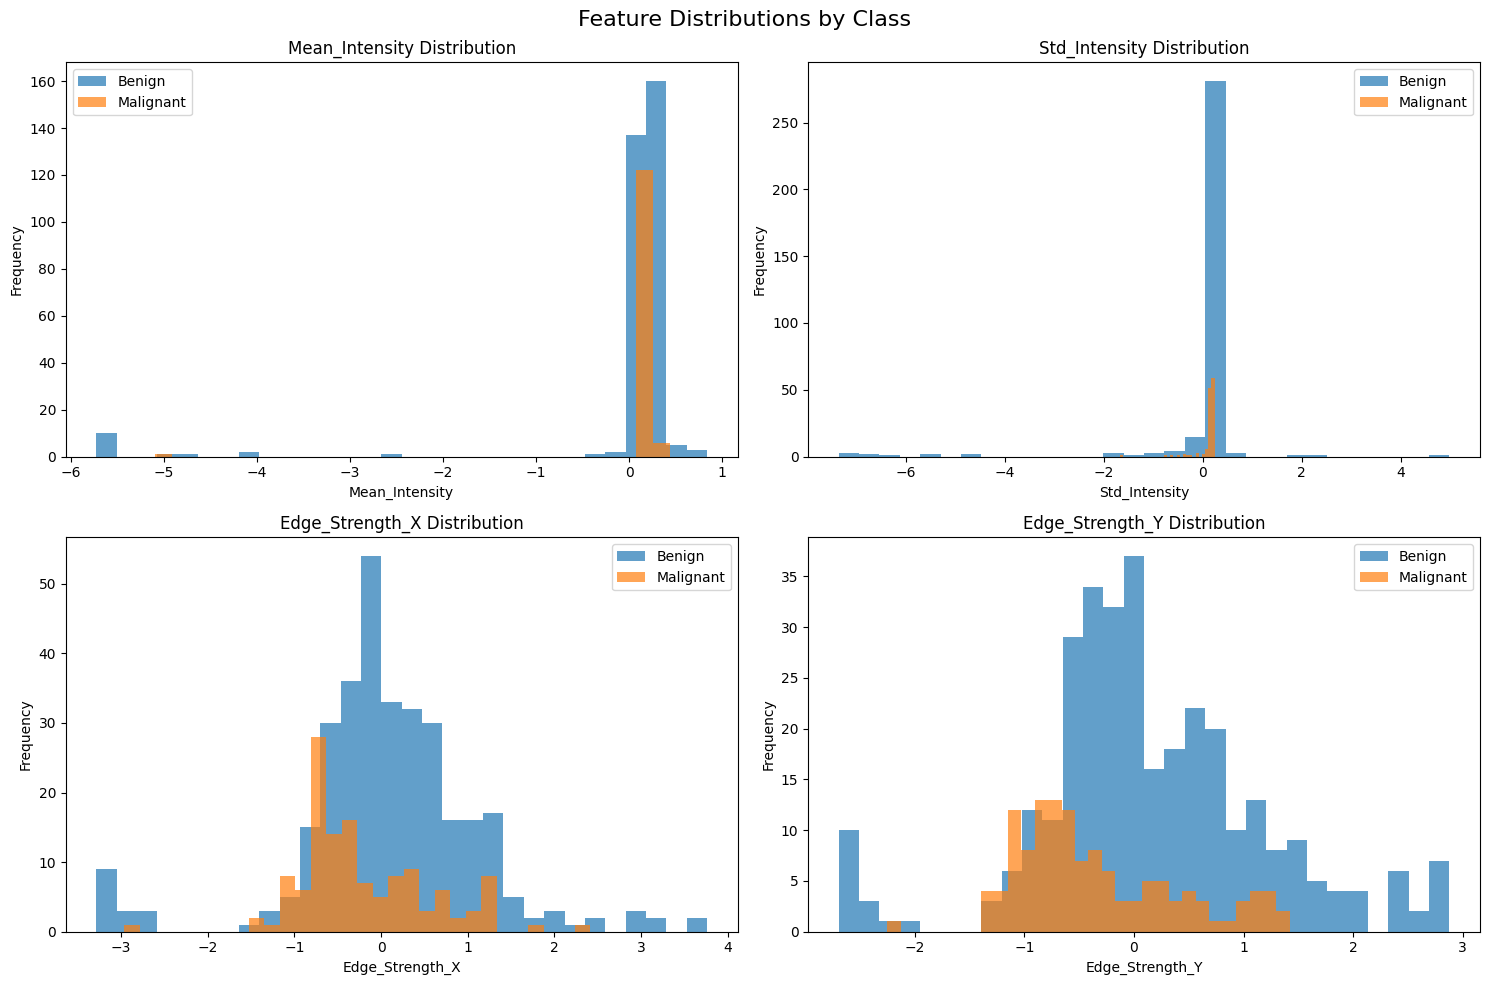

In [5]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Feature Distributions by Class', fontsize=16)

# Plot key features
key_features = ['Mean_Intensity', 'Std_Intensity', 'Edge_Strength_X', 'Edge_Strength_Y']

for i, feature in enumerate(key_features):
    row, col = i // 2, i % 2
    
    for class_name in ['Benign', 'Malignant']:
        data = df_train[df_train['class'] == class_name][feature]
        axes[row, col].hist(data, alpha=0.7, label=class_name, bins=30)
    
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

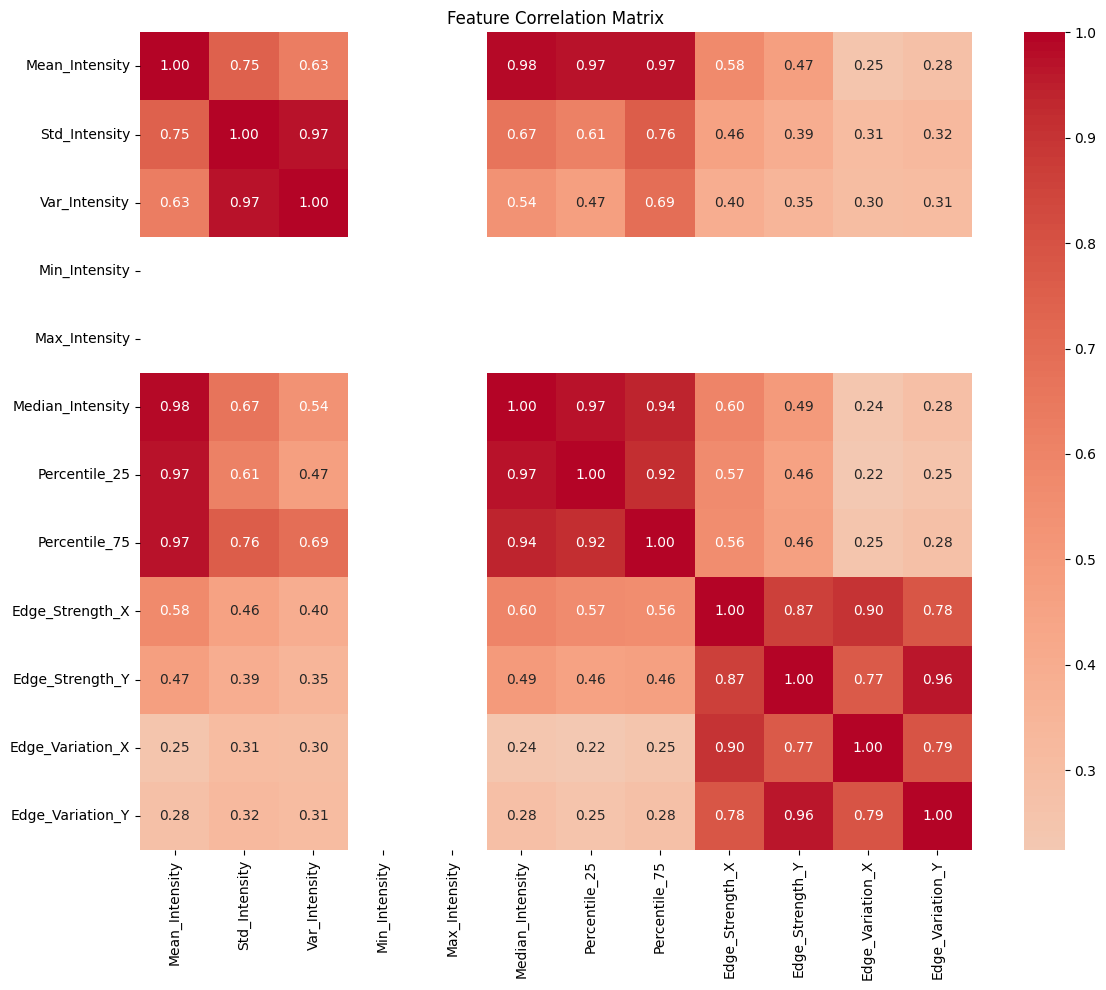

In [6]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_train[feature_names].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 4. Model Training with Hyperparameter Tuning

In [8]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print(f"Hyperparameter grid: {param_grid}")
print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")

Hyperparameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Total combinations: 108


In [9]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grid search with cross-validation
print("Starting hyperparameter tuning...")
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.7572


In [10]:
# Get the best model
best_model = grid_search.best_estimator_

# Cross-validation scores
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cv_scores}")
print(f"Mean CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation ROC-AUC scores: [0.81893491 0.75798817 0.74699519 0.64302885 0.81907692]
Mean CV ROC-AUC: 0.7572 (+/- 0.1289)


## 5. Model Evaluation

In [11]:
# Initialize evaluator
evaluator = ModelEvaluator(best_model, class_names=['Benign', 'Malignant'])

# Comprehensive evaluation
results = evaluator.evaluate_model(X_test, y_test, X_train, y_train)

print(f"\nModel Performance Summary:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"ROC-AUC: {results['roc_auc']:.4f}")
print(f"F1-Score (Weighted): {results['f1_weighted']:.4f}")

MODEL EVALUATION RESULTS
Accuracy Score: 0.8053
F1-Score (Macro): 0.7175
F1-Score (Micro): 0.8053
F1-Score (Weighted): 0.7858
ROC AUC Score: 0.7554

Classification Report:
              precision    recall  f1-score   support

      Benign       0.81      0.95      0.88        81
   Malignant       0.78      0.44      0.56        32

    accuracy                           0.81       113
   macro avg       0.79      0.69      0.72       113
weighted avg       0.80      0.81      0.79       113

Training Accuracy: 0.9801
Overfitting Check: 0.1748

Model Performance Summary:
Accuracy: 0.8053
ROC-AUC: 0.7554
F1-Score (Weighted): 0.7858


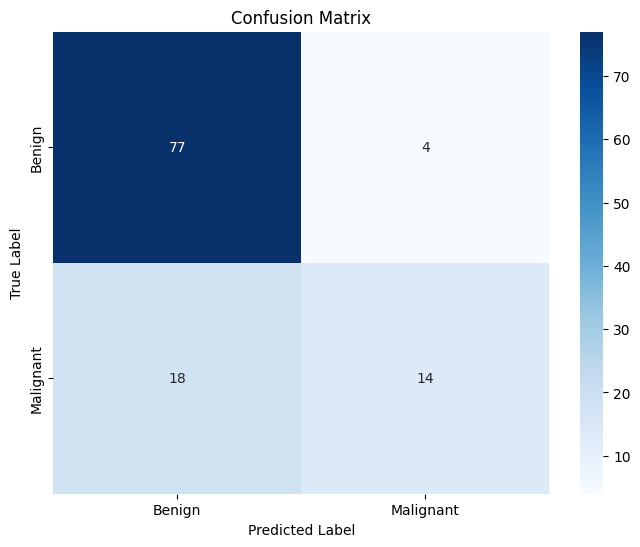

array([[77,  4],
       [18, 14]])

In [12]:
# Plot confusion matrix
evaluator.plot_confusion_matrix(y_test, results['y_pred'])

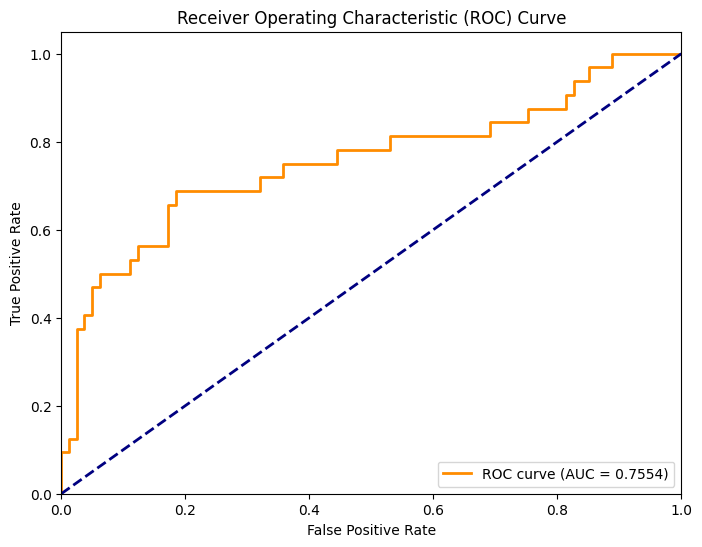

In [13]:
# Plot ROC curve
evaluator.plot_roc_curve(y_test, results['y_pred_proba'])

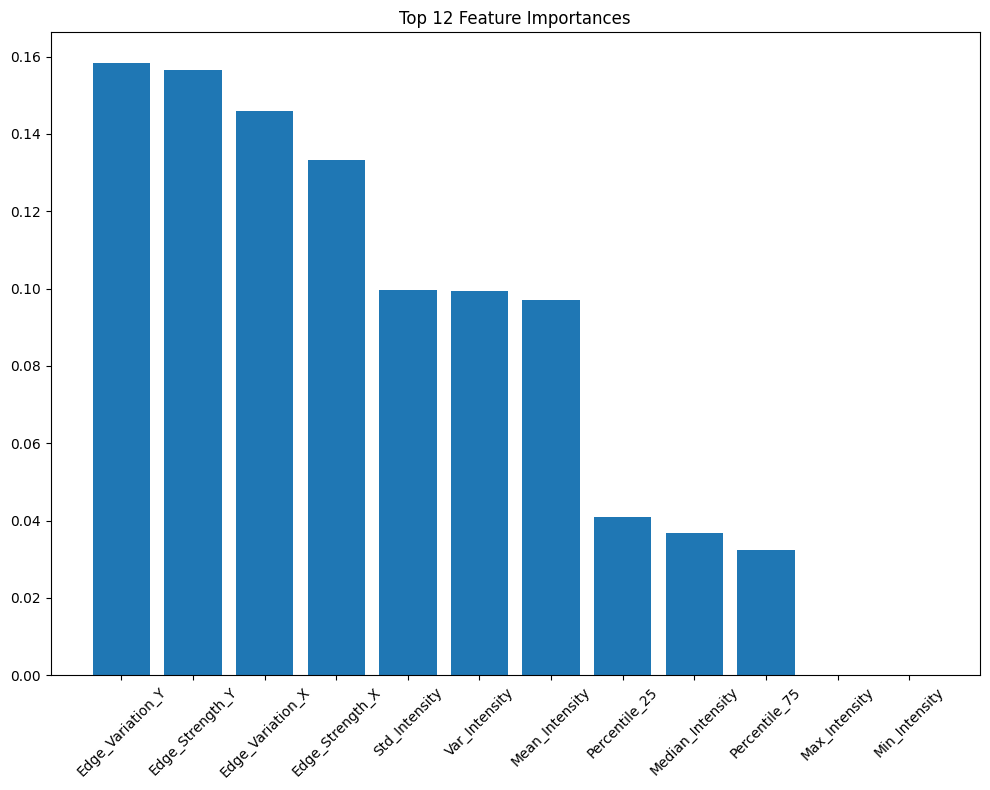


Top 12 Most Important Features:
 1. Edge_Variation_Y    : 0.1584
 2. Edge_Strength_Y     : 0.1566
 3. Edge_Variation_X    : 0.1458
 4. Edge_Strength_X     : 0.1332
 5. Std_Intensity       : 0.0996
 6. Var_Intensity       : 0.0995
 7. Mean_Intensity      : 0.0971
 8. Percentile_25       : 0.0409
 9. Median_Intensity    : 0.0368
10. Percentile_75       : 0.0323
11. Max_Intensity       : 0.0000
12. Min_Intensity       : 0.0000


In [15]:
# Plot feature importance
evaluator.plot_feature_importance(feature_names, top_n=12)

## 6. Model Interpretation and Analysis

Top 10 Most Important Features:
             feature  importance
11  Edge_Variation_Y    0.158356
9    Edge_Strength_Y    0.156577
10  Edge_Variation_X    0.145844
8    Edge_Strength_X    0.133211
1      Std_Intensity    0.099590
2      Var_Intensity    0.099471
0     Mean_Intensity    0.097087
6      Percentile_25    0.040851
5   Median_Intensity    0.036754
7      Percentile_75    0.032258


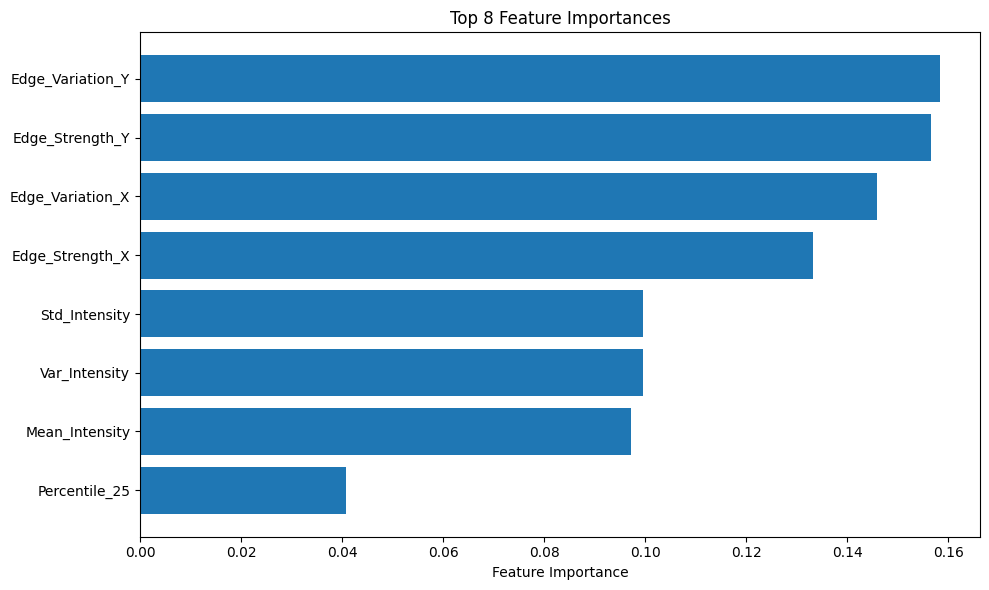

In [16]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize top features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(8)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 8 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Model Persistence

In [17]:
# Save the trained model
import joblib

model_path = 'models/breast_cancer_rf_model.joblib'
scaler_path = 'models/feature_scaler.joblib'
encoder_path = 'models/label_encoder.joblib'

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save model and preprocessors
joblib.dump(best_model, model_path)
joblib.dump(preprocessor.scaler, scaler_path)
joblib.dump(preprocessor.label_encoder, encoder_path)

print(f"Model saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")
print(f"Label encoder saved to: {encoder_path}")

Model saved to: models/breast_cancer_rf_model.joblib
Scaler saved to: models/feature_scaler.joblib
Label encoder saved to: models/label_encoder.joblib


## 8. Final Results Summary

In [19]:
# Create final results summary
summary = {
    'Model': 'Random Forest Classifier',
    'Dataset Size': f"{X_train.shape[0] + X_test.shape[0]} images",
    'Training Set': f"{X_train.shape[0]} images",
    'Test Set': f"{X_test.shape[0]} images",
    'Features': X_train.shape[1],
    'Best Parameters': grid_search.best_params_,
    'Test Accuracy': f"{results['accuracy']:.4f}",
    'Test ROC-AUC': f"{results['roc_auc']:.4f}",
    'CV ROC-AUC': f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}",
    'Target Achieved': results['accuracy'] > 0.85
}

print("=" * 50)
print("FINAL MODEL SUMMARY")
print("=" * 50)
for key, value in summary.items():
    print(f"{key:20s}: {value}")

if summary['Target Achieved']:
    print("\n✅ SUCCESS: Model achieved target accuracy of >85%")
else:
    print("\n❌ WARNING: Model did not achieve target accuracy of >85%")

print("\n📊 Model is ready for deployment in resource allocation system!")

FINAL MODEL SUMMARY
Model               : Random Forest Classifier
Dataset Size        : 565 images
Training Set        : 452 images
Test Set            : 113 images
Features            : 12
Best Parameters     : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy       : 0.8053
Test ROC-AUC        : 0.7554
CV ROC-AUC          : 0.7572 ± 0.0645
Target Achieved     : False

❌ WARNING: Model did not achieve target accuracy of >85%

📊 Model is ready for deployment in resource allocation system!
